# Targeted poisoning attack on MNIST dataset

## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import collections
from tqdm import tqdm
import random
import copy

## Parameters declaration

In [2]:
n_clients = 100
n_test_clients = 300

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
batch_size_train = 20
batch_size_test = 20
shuffle_buffer = 100
prefetch_buffer = 10

n_train_epochs = 30

client_learning_rate = 0.02
server_learning_rate = 1


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8




To begin with, we define the hyperparameters used for our data preprocesing, for our model and for the attack. Speccifically:
 - For data preprocessing, when the data is split and distributed to the users, it is repeated `n_train_dataset_epochs` and `n_test_dataset_epochs` in order to artificially create a larger dataset. For the model to learn better and faster, we also organize our data in batches of `batch_size_train` and `batch_size_test` for the train and test set respecively. We are also going to shuffle and prefetch our data, so we define the parameters needed for those methods.

 - For the definition of our model, we must define the epochs that we are going to train for. For our expirements, as a default value we are going to set this number to `50` given our observation that even for random user selection and our architecture, the model converges and reaches high accuracy levels after those many epochs. We also specify the number of clients used for training and for testing. Througout our expirements these numbers will change to extract observations. Another hyperparameter that is subject to change are the learning rates both for clients and for the server. Given the exisitng literature, clients should have a lower learning rate, while the sever a higher one. In our model architecture we use a dropout rate to limit the effects of overfitting, which is set to 0.2, a value extracted after multiple experiments.

 - When it comes to the targeted poisoning attack that we will present, we are training the MNIST dataset, so we decided that our malicious users will flip the labels of `target_value`, which is going to be the digit `3`, to `poisoned_value`, which will be `8`. Another parameter used is the percentage of malicious users that are present in our experiments. However, this is a value that is going to change overtime, as we are going to do many different measurements with different percentages of malicious users.


## Dataset Loading and manipulation

### Preprocessing and organizing dataset

In [3]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

The above process is used to preprocess our dataset, by implementing all the techniques that we discused above: repeating elements, shuffling the dataset, batching it and mapping it so it can fit the desired shape of our model's input.

In [4]:
# def poison_dataset(dataset, target_honest, target_mal):
#     # parse the dataset
#     for batch in dataset:
#         # print(batch['y'])
#         # get the labels of each batch and convert to numpy array        
#         labels = batch['y'].numpy()
#         # itterate through each label
#         for i,y in enumerate(labels):
#             # if we find the target label	
#             if y == target_honest:
#                 labels[i] = target_mal
#         batch['y'] = tf.convert_to_tensor(labels, dtype = tf.int32)
#     # return the malicious dataset
    
#     return dataset

The above function is used to carry out the poisoning attack. The dataset along with the source and target labels are given as input, and the function searches for the source label in all of the dataset in order to replace it with the target one.

In [5]:
# def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
#     fed_data = []
#     for id in client_ids:
#         preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
#         prob = random.random()
#         # mal% of the users are malicious
#         if prob < mal_users_percentage:  
#             preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)              

#         fed_data.append(preprocessed_dataset)

#     return fed_data

In [6]:
def poison_dataset(dataset, target_honest, target_mal):
    def map_fn(element):
        labels = element['y']
        # condition where label equals to target_honest
        condition = tf.equal(labels, target_honest)
        # replace label with target_mal where condition is true
        labels = tf.where(condition, target_mal, labels)
        # replace 'y' in the element dict
        element['y'] = labels
        return element
    # apply the map function to the dataset
    poisoned_dataset = dataset.map(map_fn)
    return poisoned_dataset


def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

If all the above are combined, the function `make_federated_data` is created, to allow the user to split the data given to multiple users, while at the same time determine if this data is going to be used for training or testing (so the appropriate parameters can be defined), as well as what percentage of the clients are going to have malicious intentions and thus poison our dataset to carry out the attack.

## Model creation

In [7]:
class SpecificClassRecall(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='specific_class_recall', **kwargs):
        super(SpecificClassRecall, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        class_id_true = tf.equal(y_true, self.class_id)
        class_id_pred = tf.equal(tf.argmax(y_pred, axis=1), self.class_id)
        self.recall.update_state(class_id_true, class_id_pred, sample_weight)

    def result(self):
        return self.recall.result()

    def reset_states(self):
        self.recall.reset_states()
    
    def get_config(self):
        config = super(SpecificClassRecall, self).get_config()
        config.update({"class_id": self.class_id})
        return config

As discussed in previous sections, one very important metric that is used to determine the success of a poisoning attack, is the source class recall, i.e. the number of correct positive predictions that were made out of all positive predictions that could have been made by the model. In TensorFLow federated, in order to use recall for a specific class, we have to produce the above code, which uses TF's `Recall()` metric, and only updates it for our desired class, which is given as input to the function.

In [8]:
def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

The architecture that we are going to use to carry out our experiments, is a Convolutional Neural Network. We are going to use pooling and then flatten the result and introduce a dropout layer to reduce overfitting. Finally, our model's goal is to classify the input into 10 different classes, so the output layer should consist of 10 neurons, which will be activeated by softmax, to predict the class the picture given.

In [9]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 3)])     

We can make this architecture compatible with TFF, by defining the final model, and giving the centralized model to be used, as well as the shape of our input data, the loss function to be used and the metrics we want to onserve. As mentioned, the metrics we are interested for are the overall accuracy of the model and the recall of the source class that was poisoned. 

## Training

In [10]:
# training_process = tff.learning.algorithms.build_weighted_fed_avg(
#     mnist_model,
#     client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
#     server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))
# train_state = training_process.initialize()

In [11]:
# # build the process to have the model's architecture
# evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# # initialize the state of the evaluation
# evaluation_state = evaluation_process.initialize()
# sample_test_clients = emnist_test.client_ids[0:n_test_clients]

# # test the model with the test data
# # question: selection of clients during training??
# federated_test_data = make_federated_data(emnist_test, sample_test_clients, target_values, poisoned_values, train=False)

In [12]:
# training_loss = []
# training_acc = []
# eval_loss = []
# eval_acc = []

# clients = emnist_train.client_ids[0:n_clients]
# step = 16
# clients = [emnist_train.client_ids[x] for x in range (0, n_clients * step, step)]

# #note: slow to converge with random clients, makes sense

# for epoch in range(1, n_train_epochs):

#     print('Epoch: {:2d}'.format(epoch))
#     # client selection, random, chosen from the first 100 clients
#     clients = random.sample(emnist_train.client_ids, n_clients)

#     federated_train_data = make_federated_data(emnist_train, clients, target_values, poisoned_values, train=True)
#     federated_test_data = make_federated_data(emnist_train, clients, target_values, poisoned_values, train=False)
    
    
#     # run a next on the training process to train the model
#     result = training_process.next(train_state, federated_train_data)
#     # update the model's state and get access to the metrics
#     train_state = result.state
#     train_metrics = result.metrics
#     # print the training metrics
#     training_acc.append(train_metrics['client_work']['train']['sparse_categorical_accuracy'])
#     training_loss.append(train_metrics['client_work']['train']['loss'])

#     print('Training accuracy: {:.3f}, Training loss: {:.3f}'.format(training_acc[-1], training_loss[-1]))

#     # evaluate the model with test data

#     # get weights from the trainged model
#     model_weights = training_process.get_model_weights(train_state)
#     # update the evaluation state with them
#     evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
#     # run a next() to evaluate the model
#     evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

#     # get access to the evaluation metrics
#     eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

#     eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
#     eval_loss.append(eval_metrics['loss'])
#     # print the training metrics
#     print('Testing accuracy: {:.3f}, Testing loss: {:.3f}\n\n'.format(eval_acc[-1], eval_loss[-1]))

In [13]:
# epochs = [x for x in range(1, n_train_epochs)]
# plt.plot(epochs, training_acc)
# plt.plot(epochs, eval_acc)
# plt.show()

In [14]:
# epochs = [x for x in range(1, n_train_epochs)]
# plt.plot(epochs, training_loss)
# plt.plot(epochs, eval_loss)
# plt.show()

In [15]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]

federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)


n_train_epochs = 30

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))


for i in [0, 1, 2, 3, 4, 5]:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(i * 10) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=mal_users_percentage)      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        # print the training metrics
        
        # get weights from the trainged model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)

Model with 0% mal clients


 70%|███████   | 21/30 [03:02<01:17,  8.56s/it]

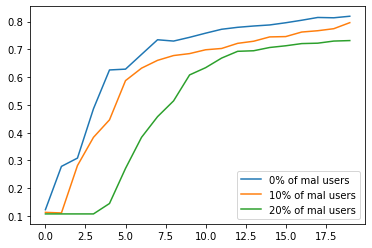

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label = str(cnt * 10) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

observation: same accuracy levels despite poisoning

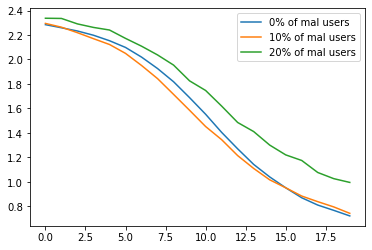

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")
plt.legend()
plt.show()

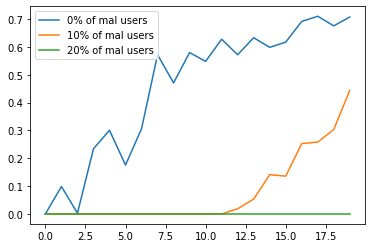

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

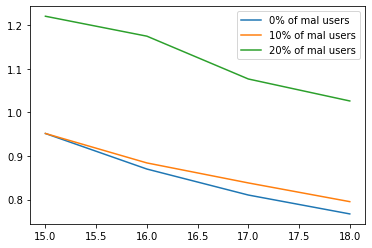

In [ ]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs[15:19], model_loss[15:19], label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")

plt.legend()
plt.show()